# Libraries

In [1]:
# Base libraries
import os
from os.path import isfile, join
import numpy as np
import random
# NetworkX
import networkx as nx
import osmnx as ox
# Torch
import torch
from torch_geometric.nn import GAE
from torch_geometric.utils import from_networkx, train_test_split_edges
from torch_geometric.loader import GraphSAINTNodeSampler
# GNN models
from gnnuf_models import *
# OS environment setup
from local_directories import *

/opt/anaconda3/envs/gnn-urban-form/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reset random seeds
random_seed = 2674
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Run on CUDA")
else:
    print("Run on CPU")

Run on CPU


# Preliminary exploratory analysis

## Check Leicester's graph

In [3]:
# Load Leciester's graph
leicester = ox.io.load_graphml(bulk_storage_directory + "/osmnx/raw/leicester-1864.graphml")

In [4]:
# Check the nodes to find the city centre
for node in leicester.nodes:
    if (
        -1.135 < leicester.nodes[node]["x"] < -1.131 and
        52.634 < leicester.nodes[node]["y"] < 52.638
        ):
        print(f"{node=}")
        print(f"{leicester.nodes[node]}\n")
del node

node=18731569
{'y': 52.6378249, 'x': -1.1345688, 'street_count': 3, 'elevation': 65.0, 'elevation_aster': '68', 'elevation_srtm': '65'}

node=20835480
{'y': 52.6340963, 'x': -1.1347561, 'street_count': 3, 'elevation': 73.0, 'elevation_aster': '83', 'elevation_srtm': '73'}

node=20937254
{'y': 52.6366647, 'x': -1.1343807, 'street_count': 1, 'elevation': 71.0, 'elevation_aster': '74', 'elevation_srtm': '71'}

node=24644030
{'y': 52.6340889, 'x': -1.1323802, 'street_count': 1, 'elevation': 65.0, 'elevation_aster': '65', 'elevation_srtm': '73'}

node=24644069
{'y': 52.6344851, 'x': -1.1324197, 'street_count': 3, 'elevation': 62.0, 'elevation_aster': '62', 'elevation_srtm': '73'}

node=24644073
{'y': 52.634293, 'x': -1.1319862, 'street_count': 1, 'elevation': 63.0, 'elevation_aster': '63', 'elevation_srtm': '72'}

node=621175630
{'y': 52.6345435, 'x': -1.1349131, 'street_count': 1, 'elevation': 73.0, 'elevation_aster': '84', 'elevation_srtm': '73'}



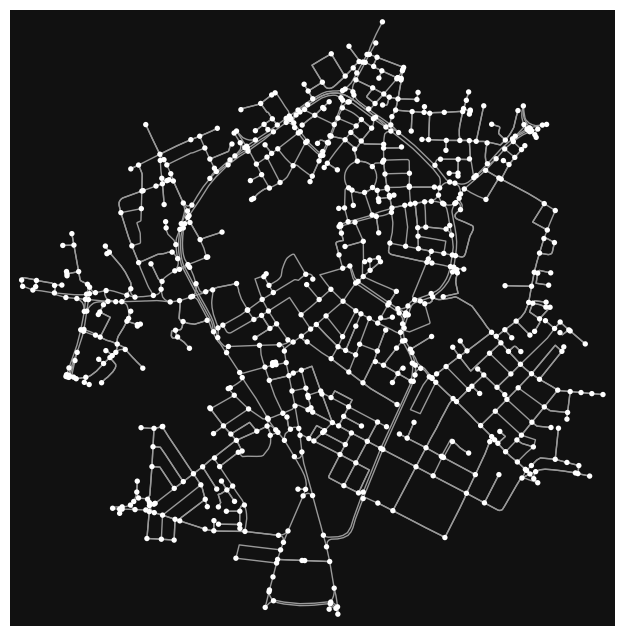

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
# A mile from node 24644030 encompass about the whole of the Leicester's city centre
leicester_town = nx.generators.ego_graph(leicester, 24644030, radius=1609.34, undirected=True, distance="length")
# Draw unprojected graph
leicester_town_projected = ox.project_graph(leicester_town)
ox.plot_graph(leicester_town_projected)
# ... or draw unprojected graph
# nx.draw(leicester_town, node_size=10, edge_color="#666666")

## Create line graph

In [6]:
# Create the line graph for Leicester's city centre
leicester_town_line = nx.line_graph(leicester_town)
# Draw unprojected graph
# nx.draw(leicester_town_line, node_size=10, edge_color="#666666")

In [7]:
# Combine street length and grade_abs
# as attribute nodes for the line graph for pytorch geometric
leicester_town_edges_length = nx.get_edge_attributes(leicester_town, "length")
leicester_town_edges_grade_abs = nx.get_edge_attributes(leicester_town, "grade_abs")
for node in leicester_town_line.nodes():
    leicester_town_line.nodes[node]["x"] = [
        leicester_town_edges_length[(node[0], node[1], 0)],
        leicester_town_edges_grade_abs[(node[0], node[1], 0)]
    ]
del node

In [8]:
leicester_town_line.nodes[next(iter(leicester_town_line.nodes()))]

{'x': [36.128, 0.055]}

In [9]:
leicester_town_line_pyg_graph = from_networkx(leicester_town_line)
leicester_town_line_pyg_graph

Data(x=[1525, 2], edge_index=[2, 3310])

# Graph Neural network

## Load the data

In [10]:
import random
import math
import networkx as nx

import torch
from torch_geometric.data import InMemoryDataset


class OSMxDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Just check if Leicester's graph is there
        return ["leicester-1864.graphml"]

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def download(self):
        print("Haven't got time to implement this. Please download the data manually -.- ")

    def process(self):
        graphml_file_names = [
            join(osmnx_dir + "/raw", f)
            for f in os.listdir(osmnx_dir + "/raw")
            if f[-8:] == ".graphml"
            if isfile(join(osmnx_dir + "/raw", f))]

        neighbourhoods_list = []

        for graphml_file_name in graphml_file_names:

            print(f"Processing: {graphml_file_name}")

            G = ox.io.load_graphml(graphml_file_name)

            # Sample 1% of nodes
            sample_nodes = random.sample(list(G.nodes), math.ceil(len(G.nodes)*0.01))
            #sample_nodes = random.sample(list(G.nodes), math.ceil(10))

            for sampled_node in sample_nodes:

                sampled_ego_graph = nx.generators.ego_graph(
                    G, sampled_node,
                    radius=2000, undirected=True, distance="length"
                )

                if len(sampled_ego_graph.nodes) > 32:

                    # for seg_node in sampled_ego_graph.nodes:
                    #     ks = [k for k in sampled_ego_graph.nodes[seg_node]]
                    #     for k in ks:
                    #         del sampled_ego_graph.nodes[seg_node][k]
                    #     sampled_ego_graph.nodes[seg_node]["x"] = 1.0
                    # for seg_edge in sampled_ego_graph.edges:
                    #     ks = [k for k in sampled_ego_graph.edges[seg_edge]] # if k != "length"
                    #     for k in ks:
                    #         del sampled_ego_graph.edges[seg_edge][k]
                    
                    seg_edges_length = nx.get_edge_attributes(sampled_ego_graph, "length")
                    seg_edges_edges_grade_abs = nx.get_edge_attributes(sampled_ego_graph, "grade_abs")
                    
                    seg_linegraph = nx.line_graph(sampled_ego_graph)
                    for seglg_node in seg_linegraph.nodes():
                        seg_linegraph.nodes[seglg_node]["x"] = [
                            seg_edges_length[(seglg_node[0], seglg_node[1], 0)],
                            seg_edges_edges_grade_abs[(seglg_node[0], seglg_node[1], 0)]
                        ]
                        # print(seg_edges_length[(seglg_node[0], seglg_node[1], 0)])
                        # print(seg_edges_edges_grade_abs[(seglg_node[0], seglg_node[1], 0)])
                        # print("\n")
                    del seglg_node

                    # print([sampled_ego_graph.nodes[n] for n in sampled_ego_graph.nodes()])

                    pyg_graph = from_networkx(seg_linegraph)
                    #pyg_graph.x = pyg_graph.x.unsqueeze(1)

                    neighbourhoods_list.append(pyg_graph)
                    #print(f"Added neighbourhood graph with {len(sampled_ego_graph.nodes)} nodes")

        self.data, self.slices = self.collate(neighbourhoods_list)
        torch.save((self.data, self.slices), self.processed_paths[0])

osmnx_dir = bulk_storage_directory + "/osmnx"
osmnx_dataset = OSMxDataset(osmnx_dir)

Processing...


Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/blackburn-1778.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/cambridge-1965.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/southport-1756.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/luton-1920.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/cudworth-1841.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/littlehampton-1919.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/cardiff-1741.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/kidderminster-1793.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/wishaw-1722.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/great_wyrley-1810.graphml
Processing: /Users/sds27/repos/gnn-urban-form/storage/osmnx/raw/basildon-1978.graphml
Processing: /Users/sds27/repos/gnn-urban-fo

/opt/anaconda3/envs/gnn-urban-form/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
Done!


In [11]:
len(osmnx_dataset)

11397

Define the model

In [13]:
from gnnuf_models import VanillaGCNEncoder

model = GAE(VanillaGCNEncoder(2, 128, 64))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

print(model)

GAE(
  (encoder): VanillaGCNEncoder(
    (en_linear1): Linear(in_features=2, out_features=2, bias=True)
    (en_conv1): GCNConv(2, 128)
    (en_conv2): GCNConv(128, 128)
    (en_linear2): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): InnerProductDecoder()
)


In [14]:
from torch_geometric.loader import DataLoader
osmnx_loader = DataLoader(osmnx_dataset, batch_size=32, shuffle=True)

epochs = 100
for epoch in range(1, epochs + 1):
    print(f"{epoch=}")

    model.train()

    for osmnx_linegraph in osmnx_loader:
        optimizer.zero_grad()
        z = model.encode(osmnx_linegraph.x, osmnx_linegraph.edge_index)
        loss = model.recon_loss(z, osmnx_linegraph.edge_index)
        osmnx_linegraph_loss = float(loss)
        print(f"{osmnx_linegraph_loss=}")
        loss.backward()
        optimizer.step()


epoch=1
osmnx_linegraph_loss=28.901254653930664
osmnx_linegraph_loss=30.678638458251953
osmnx_linegraph_loss=29.661474227905273
osmnx_linegraph_loss=29.930206298828125
osmnx_linegraph_loss=28.021459579467773
osmnx_linegraph_loss=28.660236358642578
osmnx_linegraph_loss=28.62717056274414
osmnx_linegraph_loss=28.688220977783203
osmnx_linegraph_loss=26.85089111328125
osmnx_linegraph_loss=26.08814239501953
osmnx_linegraph_loss=27.87529754638672
osmnx_linegraph_loss=25.710453033447266
osmnx_linegraph_loss=26.687618255615234
osmnx_linegraph_loss=23.92203712463379
osmnx_linegraph_loss=23.566329956054688
osmnx_linegraph_loss=23.64769172668457
osmnx_linegraph_loss=21.948348999023438
osmnx_linegraph_loss=22.342119216918945
osmnx_linegraph_loss=19.438472747802734
osmnx_linegraph_loss=18.651784896850586
osmnx_linegraph_loss=18.671855926513672
osmnx_linegraph_loss=17.772253036499023
osmnx_linegraph_loss=15.898412704467773
osmnx_linegraph_loss=15.18036937713623
osmnx_linegraph_loss=14.701138496398926

In [15]:
torch.save(model.state_dict(), bulk_storage_directory + "/models/osmnx_model_v1.pt")

In [16]:
from torch_geometric.nn import global_mean_pool
global_mean_pool(model.encode(osmnx_dataset[0].x, osmnx_dataset[0].edge_index), None)

In [17]:
global_mean_pool(model.encode(osmnx_dataset[-1].x, osmnx_dataset[-1].edge_index), None)

Testing